In [1]:
# 1) Optional auto-install (recommended on fresh environments)
AUTO_INSTALL = True

def _ensure(mod, pip_name=None, min_version=None):
    try:
        __import__(mod)
    except ImportError:
        if not AUTO_INSTALL:
            raise
        import sys, subprocess
        pkg = pip_name or mod
        if min_version:
            pkg = f"{pkg}>={min_version}"
        print("Installing", pkg, "...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("torch", "torch")
_ensure("esm", "fair-esm")
_ensure("umap", "umap-learn")
_ensure("Bio", "biopython")
_ensure("pandas", "pandas")
_ensure("numpy", "numpy")
_ensure("matplotlib", "matplotlib")
_ensure("scipy", "scipy")


/home1/zzhang201@kgi.edu/.conda/envs/tf2_16/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-25 11:15:54.017991: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 11:15:54.051345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 2) Config
from pathlib import Path

# Path to REAL training set FASTA (one sequence per record)
REAL_FASTA = "/home1/zzhang201@kgi.edu/GAN/zzGAN/gan/data/zz/train.fasta"  # <-- change me

# Generated FASTA per run: { "run_name": "/path/to/run/generated_sequences.fasta", ... }
GEN_RUNS = {
    # "20250706-154628": r"/path/to/20250706-154628/generated_sequences/generated_sequences.fasta",
    # "20250710-113045": r"/path/to/20250710-113045/generated_sequences/generated_sequences.fasta",
}

# Sampling controls for generated sequences (applied per run)
STEP_MIN = None         # e.g., 0
STEP_MAX = None         # e.g., 200000
STRIDE   = 1            # keep every k-th step (1 = keep all)
LAST_N_STEPS = None     # keep only last N distinct steps per run (after range filter)
MAX_PER_STEP = None     # cap number of sequences per step (batch), e.g., 4/8

# Optional: downsample real for speed/preview
REAL_TARGET = None      # None to keep all

# ESM / UMAP settings
ESM_MODEL = "esm2_t6_8M_UR50D"   # small & fast; can try "esm2_t12_35M_UR50D"
BATCH_SIZE = 64
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST = 0.1
UMAP_METRIC = "cosine"
UMAP_RANDOM_STATE = 0

# Output folder
OUT_DIR = Path("esm_umap_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
from pathlib import Path
import re

# Point this to the parent directory that contains your run folders
ROOT = Path("/home1/zzhang201@kgi.edu/GAN/zzGAN/logs/zz/multiG_attn_adjusted_embed/")

GEN_RUNS = {}
for fa in ROOT.glob("**/generated_sequences/generated_sequences.fasta"):
    # Prefer timestamp folder name like 20250706-154628 as the run key
    run = None
    for anc in fa.parents:
        if re.fullmatch(r"\d{8}-\d{6}", anc.name):
            run = anc.name
            break
    if run is None:
        # fallback: folder above 'generated_sequences'
        run = fa.parent.parent.name
    GEN_RUNS[run] = str(fa)

print("Discovered runs:", GEN_RUNS)


Discovered runs: {}


In [4]:
# 3) Imports
import re, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

import torch
import umap
import esm
from scipy.linalg import sqrtm


In [5]:
# 4) IO helpers (parse steps, clean sequences, FASTA IO)
AA = set("ACDEFGHIKLMNPQRSTVWYXBZ-")

def clean_seq(s: str) -> str:
    s = re.sub(r"\s+", "", s).upper()
    return "".join(ch for ch in s if ch in AA)

def parse_step_from_header(h: str) -> int:
    """Extract step from headers like '>...step001000_idx0' (returns -1 if not found)."""
    pats = [
        r"step\s*[-_ ]?\s*(\d+)",   # step123, step_123, step-123
        r"\bstep(\d+)\b",
        r"\bstep\D+(\d+)\b",
    ]
    for p in pats:
        m = re.search(p, h, flags=re.IGNORECASE)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return -1

def read_fasta_with_steps(path: str, tag: str):
    """Return DataFrame: [run, id, seq, step, length]; for REAL, step = -1."""
    rows = []
    for rec in SeqIO.parse(path, "fasta"):
        rid = str(rec.id)
        seq = clean_seq(str(rec.seq))
        if not seq:
            continue
        step = parse_step_from_header(rid) if tag != "REAL" else -1
        rows.append((tag, rid, seq, step, len(seq)))
    return pd.DataFrame(rows, columns=["run","id","seq","step","length"])

def write_fasta(df: pd.DataFrame, path: Path):
    with open(path, "w") as f:
        for _, r in df.iterrows():
            f.write(f">{r['id']}\n{r['seq']}\n")


In [6]:
# Replace the old "Load datasets" (for generated) with this CSV-based loader.
# Assumes you already ran cell #4 that defines `clean_seq`.

from pathlib import Path
import re
import pandas as pd

# One or more CSVs produced by the extractor (each has columns like:
# run, step, seq_idx, seq, wall_time_iso, event_file)
GEN_CSVS = [
    "/home1/zzhang201@kgi.edu/GAN/gen_extract_all/generated_sequences_all.csv",
    # r"/path/to/another/generated_sequences_all.csv",
]

def infer_run_from_path(p: str):
    # if "run" ever missing, try to grab timestamp folder (YYYYMMDD-HHMMSS) from event_file path
    m = re.search(r"/(\d{8}-\d{6})/", p.replace("\\", "/"))
    if m:
        return m.group(1)
    # else parent-of-parent of 'generated_sequences' or 'summaries'
    parts = p.replace("\\","/").split("/")
    for key in ("generated_sequences","summaries","setup"):
        if key in parts:
            i = parts.index(key)
            if i-1 >= 0: return parts[i-1]
    return "run_unknown"

gen_parts = []
for csv_path in GEN_CSVS:
    d = pd.read_csv(csv_path)
    # Ensure required cols exist
    if "run" not in d.columns and "event_file" in d.columns:
        d["run"] = d["event_file"].apply(infer_run_from_path)
    assert {"run","step","seq_idx","seq"}.issubset(d.columns), \
        f"Missing required columns in {csv_path}"
    # Clean & types
    d["seq"]  = d["seq"].astype(str).map(clean_seq)
    d["step"] = pd.to_numeric(d["step"], errors="coerce").astype("Int64")
    d["seq_idx"] = pd.to_numeric(d["seq_idx"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["step","seq_idx"])
    d = d[d["seq"].str.len() > 0]
    # Compose an ID compatible with the rest of the notebook
    d["id"] = d.apply(lambda r: f"{r['run']}_step{int(r['step']):06d}_idx{int(r['seq_idx'])}", axis=1)
    d["length"] = d["seq"].str.len()
    gen_parts.append(d[["run","id","seq","step","length"]])

gen_df = (pd.concat(gen_parts, ignore_index=True)
            .drop_duplicates(["run","id"])
            .reset_index(drop=True))

print("Generated sequences (all runs):", len(gen_df))

# REAL still from FASTA:
real_df = read_fasta_with_steps(REAL_FASTA, "REAL")
print("Real sequences:", len(real_df))


Generated sequences (all runs): 12000
Real sequences: 7097


In [7]:
gen_df["run"].unique()

array(['20250706-154628', '20250707-055456', '20250707-105025',
       '20250708-031511', '20250710-042044', '20250719-054302',
       '20250724-032823', '20250726-010812', '20250730-075807',
       '20250731-023622', '20250914-030651', '20250914-134953',
       '20250915-033747', '20250916-101929', '20250916-171337'],
      dtype=object)

In [9]:
# 6) Sample generated (stride/last-N/step-range) + optional downsample real; save selections
def sample_generated(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = []
    for run, g in df.groupby("run", sort=False):
        gg = g.copy()
        if STEP_MIN is not None: gg = gg[gg["step"] >= STEP_MIN]
        if STEP_MAX is not None: gg = gg[gg["step"] <= STEP_MAX]
        steps = sorted(s for s in gg["step"].unique() if s >= 0)
        if LAST_N_STEPS: steps = steps[-LAST_N_STEPS:]
        if STRIDE and STRIDE > 1: steps = steps[::STRIDE]
        keep = gg[gg["step"].isin(steps)].copy()
        if MAX_PER_STEP and MAX_PER_STEP > 0:
            keep = (keep.sort_values(["step","id"])
                        .groupby("step", as_index=False)
                        .head(MAX_PER_STEP))
        out.append(keep)
    return pd.concat(out, ignore_index=True) if out else df

gen_sel = sample_generated(gen_df)
print("Generated after sampling:", len(gen_sel))

if REAL_TARGET is not None and len(real_df) > REAL_TARGET:
    real_sel = real_df.sample(REAL_TARGET, random_state=0).reset_index(drop=True)
else:
    real_sel = real_df.copy()

real_sel.to_csv(OUT_DIR / "real_selected.csv", index=False)
gen_sel.to_csv(OUT_DIR / "gen_selected.csv", index=False)
print("Saved selections to:", OUT_DIR)


Generated after sampling: 12000
Saved selections to: esm_umap_outputs


In [10]:
# 7) ESM embedding (fit embeddings)
def load_esm(model_name: str):
    name = model_name.strip()
    if name == "esm2_t6_8M_UR50D":
        model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
        layer = 6
    elif name == "esm2_t12_35M_UR50D":
        model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
        layer = 12
    else:
        model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
        layer = 6
    return model.eval(), alphabet, layer

def embed_sequences(pairs, model, alphabet, layer, batch_size=64, device=None):
    """
    pairs: list of (id, seq) -> returns (ids, np.array [N, C]) mean-pooled token embeddings
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    batch_converter = alphabet.get_batch_converter()
    vecs, ids = [], []
    for i in range(0, len(pairs), batch_size):
        batch = pairs[i:i+batch_size]
        labels, strs, toks = batch_converter([(pid, pseq) for pid, pseq in batch])
        toks = toks.to(device)
        with torch.no_grad():
            out = model(toks, repr_layers=[layer])
            rep = out["representations"][layer]     # (B, L, C)
            rep = rep[:, 1:-1, :].mean(1)           # mean-pooled (drop special tokens)
        vecs.append(rep.cpu().numpy())
        ids.extend([pid for pid, _ in batch])
    return ids, np.vstack(vecs) if vecs else ([], np.empty((0, 0)))

# Prepare inputs
real_pairs = [(r.id, r.seq) for r in real_sel.itertuples()]
gen_pairs  = [(r.id, r.seq) for r in gen_sel.itertuples()]
print("Embedding sizes -> real:", len(real_pairs), "gen:", len(gen_pairs))

model, alphabet, layer = load_esm(ESM_MODEL)
ids_r, E_r = embed_sequences(real_pairs, model, alphabet, layer, batch_size=BATCH_SIZE)
ids_g, E_g = embed_sequences(gen_pairs,  model, alphabet, layer, batch_size=BATCH_SIZE)

np.savez_compressed(OUT_DIR / "embeddings_real.npz", ids=np.array(ids_r, dtype=object), X=E_r)
np.savez_compressed(OUT_DIR / "embeddings_gen.npz",  ids=np.array(ids_g, dtype=object), X=E_g)
print("Saved embeddings to:", OUT_DIR)


Embedding sizes -> real: 7097 gen: 12000
Saved embeddings to: esm_umap_outputs


In [11]:
# 8) UMAP: fit on REAL only, transform GEN, save coords
mapper = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric=UMAP_METRIC,
    random_state=UMAP_RANDOM_STATE,
)
Z_r = mapper.fit_transform(E_r) if len(E_r) else np.empty((0, 2))
Z_g = mapper.transform(E_g) if len(E_g) else np.empty((0, 2))

pd.DataFrame({"id": ids_r, "z1": Z_r[:,0], "z2": Z_r[:,1]}).to_csv(OUT_DIR / "umap_real.csv", index=False)
pd.DataFrame({"id": ids_g, "z1": Z_g[:,0], "z2": Z_g[:,1]}).to_csv(OUT_DIR / "umap_gen.csv", index=False)
print("Saved UMAP coords.")


/home1/zzhang201@kgi.edu/.conda/envs/tf2_16/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved UMAP coords.


In [12]:
# 9) Join steps/runs back to GEN for coloring
gen_steps = gen_sel.set_index("id")["step"].to_dict()
steps_g = np.array([gen_steps.get(i, -1) for i in ids_g], dtype=float)
run_map = gen_sel.set_index("id")["run"].to_dict()
runs_present = sorted(set(run_map.get(i, "GEN") for i in ids_g))


In [14]:
gen_sel

,run,id,seq,step,length
0,20250706-154628,20250706-154628_step000000_idx0,ECFWQIPDEKMQLKSFKKKWMGLWKSGQFISDSSSWMLQDKHF-GQ...,0,160
1,20250706-154628,20250706-154628_step000000_idx1,KRSQVKSDKIMQHSMTKWKWMLSMLLP-QWQWKKSWLWFLKKIKQI...,0,160
2,20250706-154628,20250706-154628_step000000_idx2,QEKCMWVIKIVCQ-QWKWKWKTFIQKHIQIKESQAWMLLIMHKWKT...,0,160
3,20250706-154628,20250706-154628_step000000_idx3,APMQPLLWFKSWKWQIKKKKFKLKKKMWIQPTKWMWQVLQLKGKLW...,0,160
4,20250706-154628,20250706-154628_step001000_idx0,IGIKIWSAKAYAIV-AHGIKIVSVKAYAGVDAHGIKIVSVQAYAGA...,1000,160
...,...,...,...,...,...
11995,20250916-171337,20250916-171337_step198999_idx3,QRQYVRGYARYWSISSAYVKYRAYPRTVSISSAYVKYRAYPGSVSI...,198999,160
11996,20250916-171337,20250916-171337_step199999_idx0,QRQYVRGYARYWVISSARVKVRAYPRHVSISSAYGKVRAYPRPVSI...,199999,160
11997,20250916-171337,20250916-171337_step199999_idx1,QRQYVRGYARYWVISSARQYVRAYPRYVSISSAGGYVRAYPRIVSI...,199999,160
11998,20250916-171337,20250916-171337_step199999_idx2,QRQYVRGYARYWSISSAYVNVRAYPRHVSISSAYGKYRAYPDYVSI...,199999,160


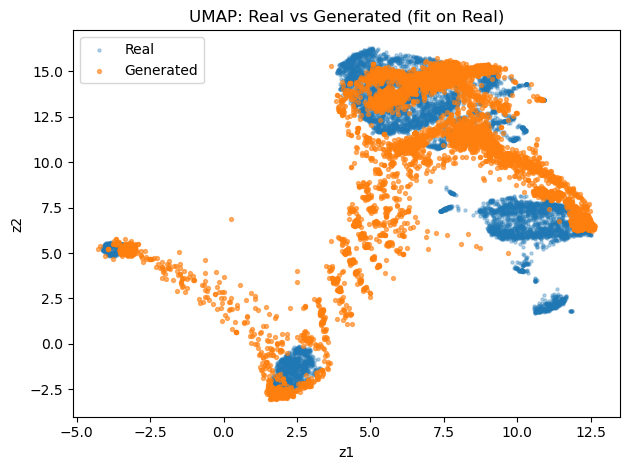

In [13]:
# 10) Plot A: Real vs Generated (all runs)
plt.figure()
if len(Z_r): plt.scatter(Z_r[:,0], Z_r[:,1], s=5, alpha=0.3, label="Real")
if len(Z_g): plt.scatter(Z_g[:,0], Z_g[:,1], s=8, alpha=0.6, label="Generated")
plt.legend()
plt.title("UMAP: Real vs Generated (fit on Real)")
plt.xlabel("z1"); plt.ylabel("z2")
plt.tight_layout()
plt.savefig(OUT_DIR / "umap_real_vs_gen.png", dpi=200)
plt.show()


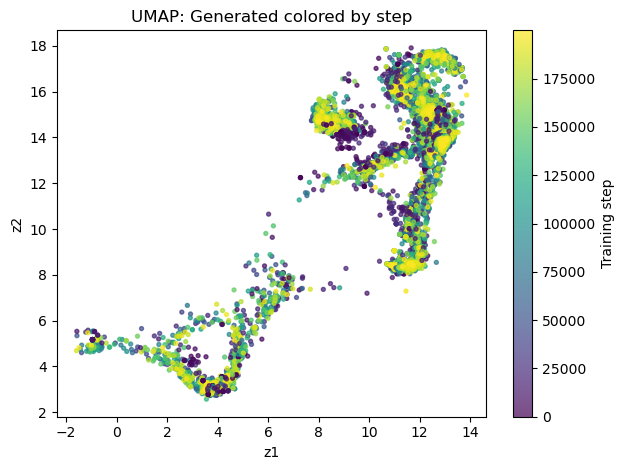

In [19]:
# 11) Plot B: Generated colored by step
plt.figure()
if len(Z_g):
    sc = plt.scatter(Z_g[:,0], Z_g[:,1], s=8, alpha=0.7, c=steps_g)
    cbar = plt.colorbar(sc); cbar.set_label("Training step")
plt.title("UMAP: Generated colored by step")
plt.xlabel("z1"); plt.ylabel("z2")
plt.tight_layout()
plt.savefig(OUT_DIR / "umap_gen_by_step.png", dpi=200)
plt.show()


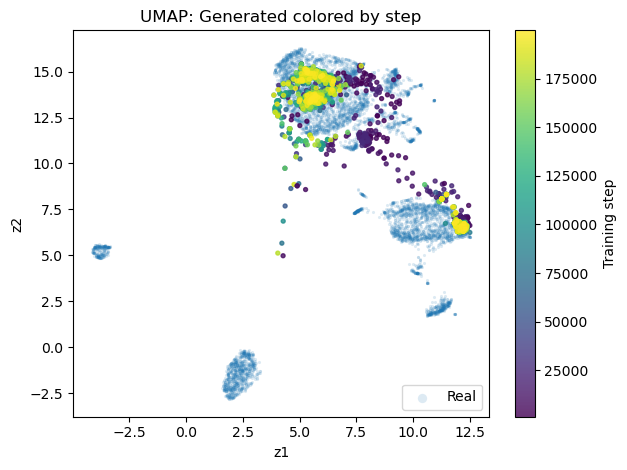

In [18]:
# 11) Plot B (modified): Generated colored by step, showing ONLY selected runs, with Real as reference + legend

# Choose the three runs to display
RUNS_TO_SHOW = {
    "20250707-055456",
    "20250708-031511",
    "20250724-032823",
}

# Build a boolean mask over generated points for the selected runs
sel_mask = np.array([run_map.get(i, None) in RUNS_TO_SHOW for i in ids_g], dtype=bool)

plt.figure()

legend_handles = []

# Real as faint background for reference
if len(Z_r):
    bg = plt.scatter(
        Z_r[:, 0], Z_r[:, 1],
        s=5, alpha=0.15, linewidths=0,
        label="Real"
    )
    legend_handles.append(bg)

# Selected generated points, colored by training step
if len(Z_g) and sel_mask.any():
    sc = plt.scatter(
        Z_g[sel_mask, 0],
        Z_g[sel_mask, 1],
        s=8,
        alpha=0.8,
        c=steps_g[sel_mask],
    )
    cbar = plt.colorbar(sc)
    cbar.set_label("Training step")

# Legend (only show the Real background entry)
if legend_handles:
    plt.legend(handles=legend_handles, loc="lower right", frameon=True, markerscale=3)

plt.title("UMAP: Generated colored by step")
plt.xlabel("z1"); plt.ylabel("z2")
plt.tight_layout()
plt.savefig(OUT_DIR / "umap_gen_by_step_SELECTED_3_RUNS.png", dpi=200)
plt.show()


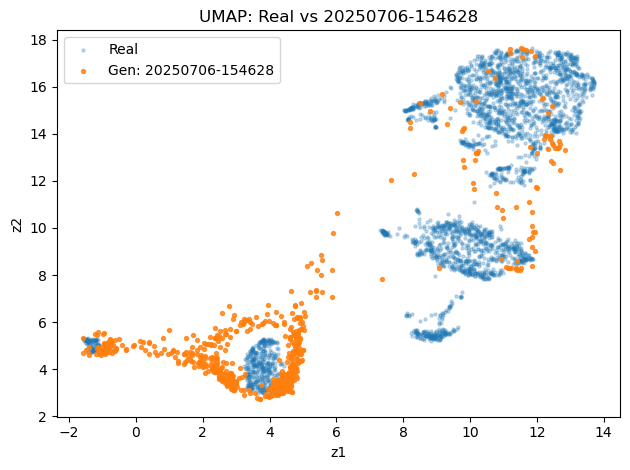

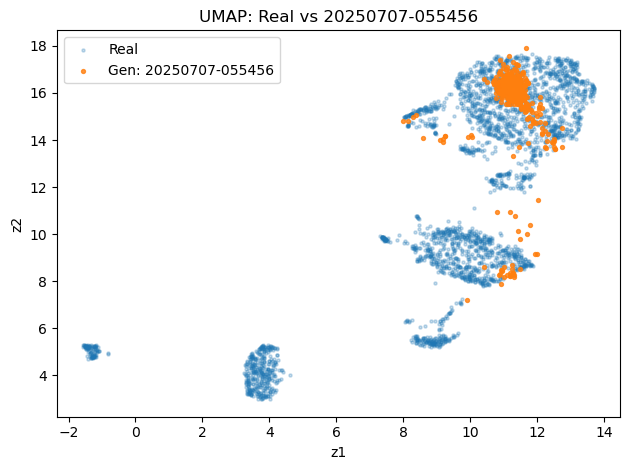

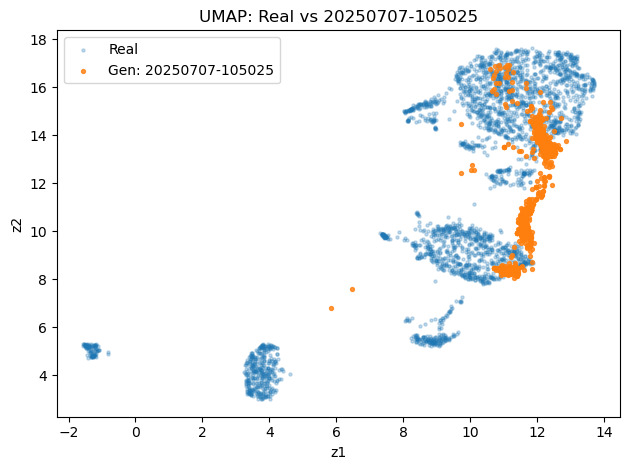

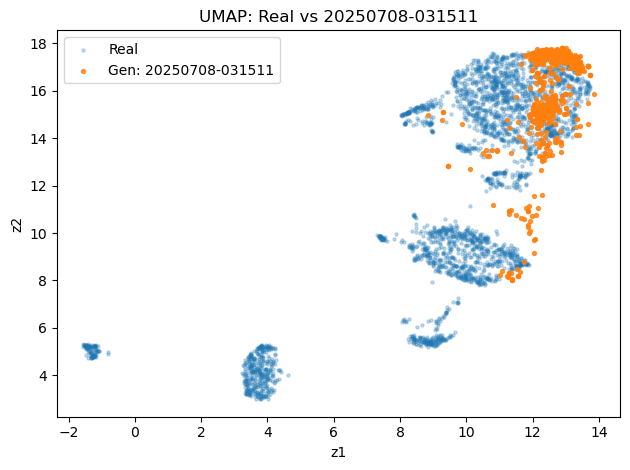

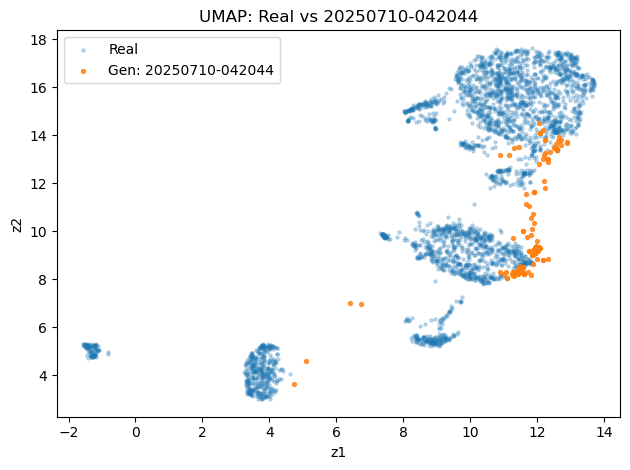

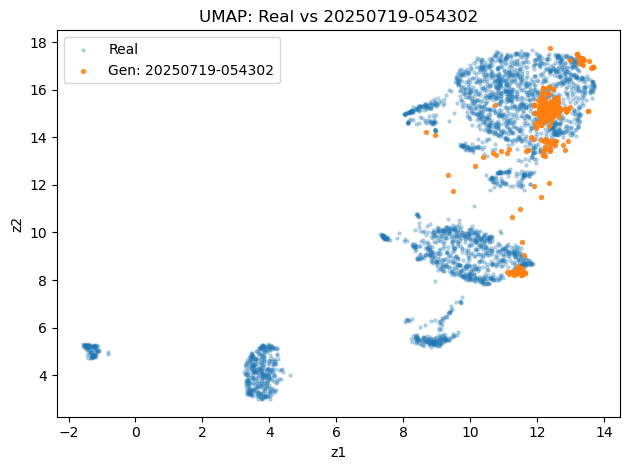

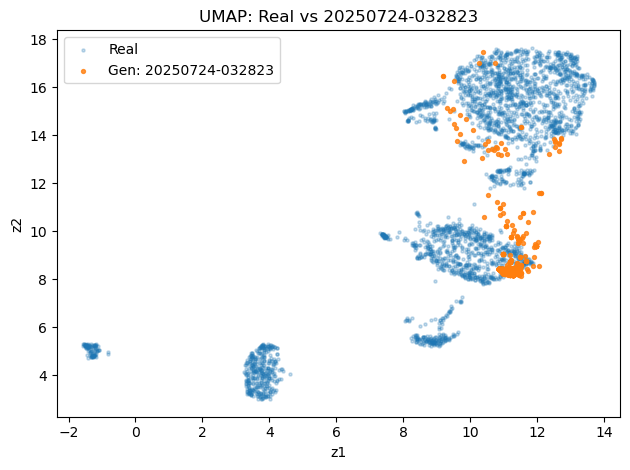

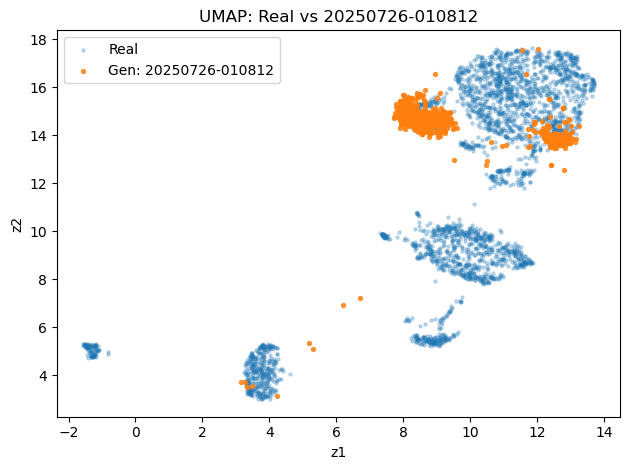

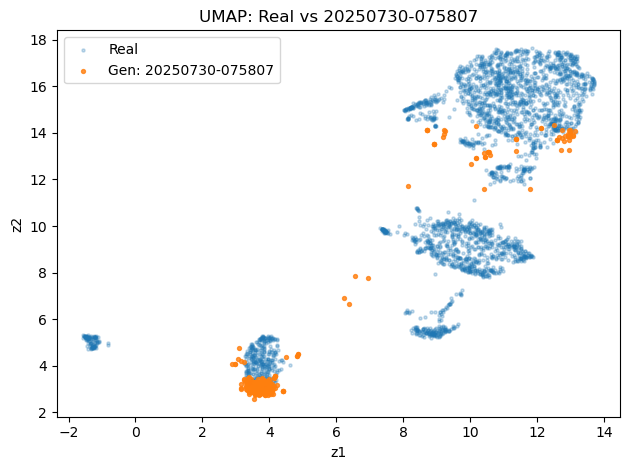

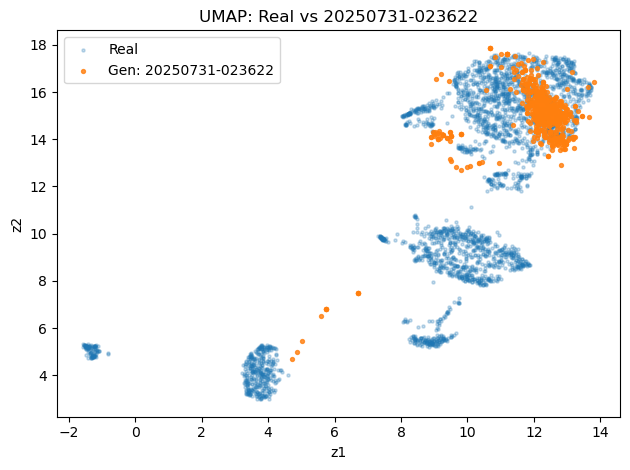

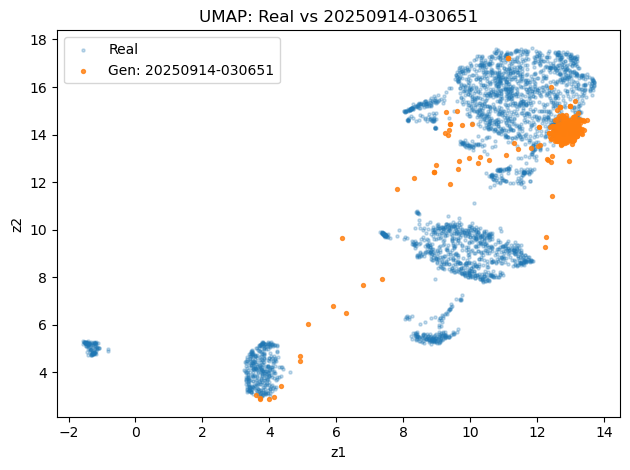

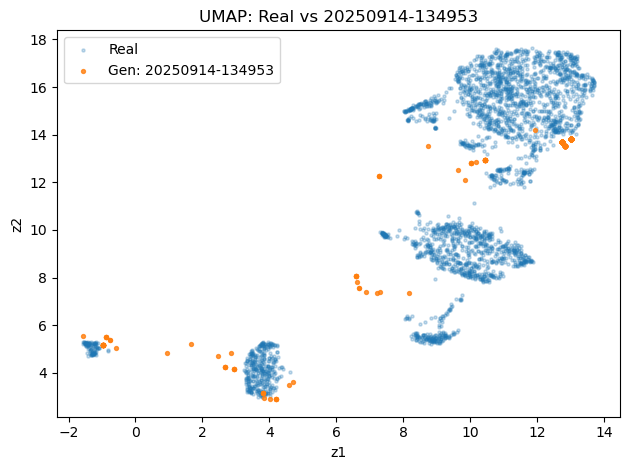

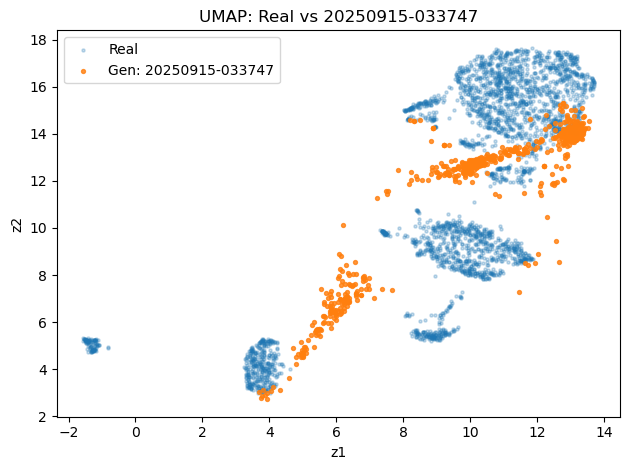

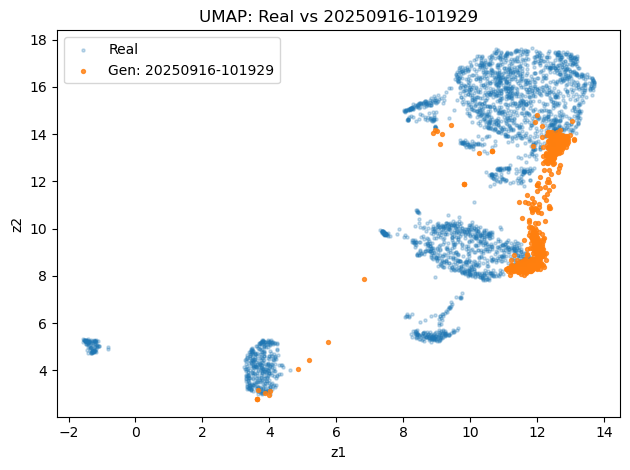

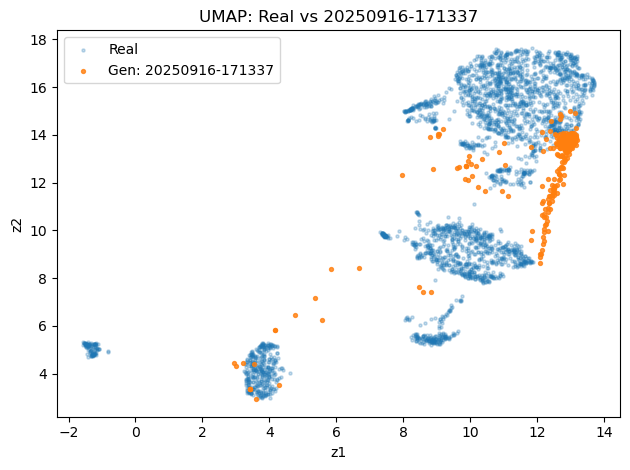

In [20]:
# 12) Plot C: Per-run overlays (one figure per run)
for run in runs_present:
    mask = np.array([run_map.get(i, "GEN")==run for i in ids_g], dtype=bool)
    if not mask.any():
        continue
    plt.figure()
    if len(Z_r): plt.scatter(Z_r[:,0], Z_r[:,1], s=5, alpha=0.25, label="Real")
    plt.scatter(Z_g[mask,0], Z_g[mask,1], s=8, alpha=0.8, label=f"Gen: {run}")
    plt.legend()
    plt.title(f"UMAP: Real vs {run}")
    plt.xlabel("z1"); plt.ylabel("z2")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"umap_real_vs_{run}.png", dpi=200)
    plt.show()


In [21]:
# 13) Fréchet distance (FID-like) in ESM space: overall + per run
def frechet(mu1, C1, mu2, C2, eps=1e-6):
    C1 = C1 + np.eye(C1.shape[0])*eps
    C2 = C2 + np.eye(C2.shape[0])*eps
    diff = mu1 - mu2
    covmean = sqrtm(C1.dot(C2))
    if np.iscomplexobj(covmean): covmean = covmean.real
    return float(diff.dot(diff) + np.trace(C1 + C2 - 2*covmean))

rows = []
if len(E_r) and len(E_g):
    mu_r, C_r = E_r.mean(0), np.cov(E_r, rowvar=False)
    # overall
    mu_g, C_g = E_g.mean(0), np.cov(E_g, rowvar=False)
    rows.append(("ALL", frechet(mu_r, C_r, mu_g, C_g), len(E_g)))
    # per run
    for run in runs_present:
        mask = np.array([run_map.get(i, "GEN")==run for i in ids_g], dtype=bool)
        if not mask.any(): continue
        mu, C = E_g[mask].mean(0), np.cov(E_g[mask], rowvar=False)
        rows.append((run, frechet(mu_r, C_r, mu, C), int(mask.sum())))

fid_df = pd.DataFrame(rows, columns=["run","fid_esm","n_gen"]) if rows else pd.DataFrame(columns=["run","fid_esm","n_gen"])
fid_df.to_csv(OUT_DIR / "fid_esm_by_run.csv", index=False)
display(fid_df.sort_values("fid_esm") if len(fid_df) else fid_df)


,run,fid_esm,n_gen
2,20250707-055456,1.831966,800
4,20250708-031511,2.064152,800
7,20250724-032823,2.521866,800
1,20250706-154628,2.624580,800
6,20250719-054302,2.692140,800
3,20250707-105025,3.642827,800
5,20250710-042044,9.470080,800
14,20250916-101929,10.176511,800
0,ALL,14.002560,12000
15,20250916-171337,20.138159,800


In [ ]:
# === Robust FID/JSD over time for three runs: with diagnostics & adaptive MIN_GROUP ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
RUNS_TO_SHOW = {
    "20250707-055456",
    "20250708-031511",
    "20250724-032823",
}
BINS_2D = 60
EPS = 1e-6
OUT_DIR = Path(OUT_DIR)
METRIC_CSV = OUT_DIR / "metrics_fid_jsd_selected_runs.csv"

# ------------------------------------------------------------
# Utilities
# ------------------------------------------------------------
def _to2d(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]
    return x

def _cov(x):
    x = _to2d(x)
    if x.shape[0] < 2:
        return np.eye(x.shape[1]) * EPS
    c = np.cov(x, rowvar=False)
    c = 0.5 * (c + c.T)
    c[np.diag_indices_from(c)] += EPS
    return c

def _bures_frechet_gaussian(mu_r, Sig_r, mu_g, Sig_g):
    mu_r = _to2d(mu_r).ravel()
    mu_g = _to2d(mu_g).ravel()
    Sig_r = 0.5 * (Sig_r + Sig_r.T)
    Sig_g = 0.5 * (Sig_g + Sig_g.T)
    er, Ur = np.linalg.eigh(Sig_r)
    er = np.clip(er, 0.0, None)
    Sr_half = Ur @ np.diag(np.sqrt(er)) @ Ur.T
    A = Sr_half @ Sig_g @ Sr_half
    A = 0.5 * (A + A.T)
    ea, _ = np.linalg.eigh(A)
    ea = np.clip(ea, 0.0, None)
    tr_sqrt = float(np.sum(np.sqrt(ea)))
    diff = mu_r - mu_g
    return float(diff @ diff + np.trace(Sig_r) + np.trace(Sig_g) - 2.0 * tr_sqrt)

def _jsd_from_histograms(P, Q, eps=1e-12):
    P = P.astype(float); Q = Q.astype(float)
    P = P / (P.sum() + eps)
    Q = Q / (Q.sum() + eps)
    M = 0.5 * (P + Q)
    def _kl(a, b):
        mask = a > 0
        return float(np.sum(a[mask] * (np.log(a[mask] + eps) - np.log(b[mask] + eps))))
    return 0.5 * _kl(P, M) + 0.5 * _kl(Q, M)

def _find_col(df, candidates):
    low = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in low:
            return low[c]
    return None

def _ensure_run_map(ids_g, run_map=None):
    if isinstance(run_map, dict) and run_map:
        return run_map
    # Try from DataFrames present in globals
    candidates = []
    for name in ["gen_sel", "gen_df", "gen_selected", "gen"]:
        if name in globals():
            obj = globals()[name]
            if isinstance(obj, pd.DataFrame) and len(obj):
                candidates.append((name, obj))
    for name, df in candidates:
        id_col = _find_col(df, ["id","seq_id","seqid","uid","gid","sample_id"])
        run_col = _find_col(df, ["run","run_id","run_name","runid","runname"])
        if id_col is not None and run_col is not None:
            mp = dict(zip(df[id_col].astype(str), df[run_col].astype(str)))
            if mp:
                print(f"[info] run_map from `{name}` using `{id_col}`/`{run_col}` ({len(mp)} entries).")
                return mp
    # Fallback: parse from id string (e.g., ".../20250707-055456/...")
    rex = re.compile(r'(20\d{6}-\d{6})')
    mp = {}
    for i in ids_g:
        s = str(i); m = rex.search(s)
        if m: mp[s] = m.group(1)
    if mp:
        print(f"[info] run_map inferred from ids_g via regex ({len(mp)} entries).")
        return mp
    raise KeyError("Unable to construct run_map. Provide a DF (gen_df/gen_sel) with [id, run] or encode run in ids_g.")

def _ensure_steps(ids_g, steps_g):
    ids_g = np.asarray(ids_g).astype(str)
    # If steps_g already aligns, use it
    if steps_g is not None and len(steps_g) == len(ids_g):
        sg = np.asarray(steps_g)
        # coerce to int if possible
        try:
            return sg.astype(int)
        except Exception:
            pass
        # regex-digits fallback
        out = []
        for s in sg:
            m = re.search(r'\d+', str(s))
            out.append(int(m.group(0)) if m else -1)
        return np.array(out, dtype=int)
    # Try from DataFrames
    for name in ["gen_sel", "gen_df", "gen_selected", "gen"]:
        if name in globals():
            df = globals()[name]
            if isinstance(df, pd.DataFrame) and len(df):
                id_col = _find_col(df, ["id","seq_id","seqid","uid","gid","sample_id"])
                step_col = _find_col(df, ["step","global_step","train_step","training_step"])
                if id_col and step_col:
                    m = dict(zip(df[id_col].astype(str), df[step_col].astype(object)))
                    out = []
                    for i in ids_g:
                        val = m.get(i, None)
                        if val is None:
                            out.append(-1)
                        else:
                            try:
                                out.append(int(val))
                            except Exception:
                                mm = re.search(r'\d+', str(val))
                                out.append(int(mm.group(0)) if mm else -1)
                    print(f"[info] steps inferred from `{name}` using `{id_col}`/`{step_col}`.")
                    return np.array(out, dtype=int)
    # Last resort: -1 everywhere
    print("[warn] Could not infer per-sample steps; setting to -1.")
    return np.full(len(ids_g), -1, dtype=int)

# ------------------------------------------------------------
# Inputs & normalization
# ------------------------------------------------------------
ids_g = np.asarray(ids_g).astype(str)
try:
    steps_g  # noqa
except NameError:
    steps_g = None
steps_g = _ensure_steps(ids_g, steps_g)

try:
    run_map  # noqa
except NameError:
    run_map = None
run_map = _ensure_run_map(ids_g, run_map)
run_arr = np.array([run_map.get(i, "") for i in ids_g], dtype=object)

# Prefer ESM for FID; fallback to UMAP if missing
use_embeddings = ("E_r" in globals()) and ("E_g" in globals()) and (E_r is not None) and (E_g is not None)
if not use_embeddings:
    print("[note] ESM embeddings not found; using UMAP coords for FID.")
    E_r_use = Z_r
    E_g_use = Z_g
else:
    E_r_use = E_r
    E_g_use = E_g

E_r_use = _to2d(np.asarray(E_r_use))
E_g_use = _to2d(np.asarray(E_g_use))
Z_r = _to2d(np.asarray(Z_r))
Z_g = _to2d(np.asarray(Z_g))

# Basic consistency checks
print(f"[diag] shapes | E_r:{E_r_use.shape}  E_g:{E_g_use.shape}  Z_r:{Z_r.shape}  Z_g:{Z_g.shape}  ids_g:{len(ids_g)}  steps_g:{len(steps_g)}")
if len(ids_g) != len(steps_g) or len(ids_g) != Z_g.shape[0] or len(ids_g) != E_g_use.shape[0]:
    print("[warn] Mismatch in lengths between ids_g/steps_g/E_g/Z_g — metrics may misalign.")

# ------------------------------------------------------------
# Selection & diagnostics
# ------------------------------------------------------------
sel_mask_runs = np.isin(run_arr, list(RUNS_TO_SHOW))
if not sel_mask_runs.any():
    print("[error] None of the selected runs are present in run_arr.")
    print("Runs present:", pd.Series(run_arr).value_counts().head(10))
    raise ValueError("Selected runs not found.")

df_idx = pd.DataFrame({
    "idx": np.arange(len(ids_g)),
    "id": ids_g,
    "run": run_arr,
    "step": steps_g
})
df_sel = df_idx[sel_mask_runs].copy()

print("\n[diag] counts by run (selected):")
print(df_sel["run"].value_counts())

print("\n[diag] counts by (run, step) (top 15):")
print(df_sel.groupby(["run","step"]).size().sort_values(ascending=False).head(15))

# ------------------------------------------------------------
# Precompute reference stats & grid
# ------------------------------------------------------------
mu_r = np.mean(E_r_use, axis=0)
Sig_r = _cov(E_r_use)

# JSD grid based on Real + selected Gen
Z_all_sel = np.vstack([Z_r, Z_g[sel_mask_runs]])
pad = 1e-9
x_min, x_max = float(Z_all_sel[:,0].min()) - pad, float(Z_all_sel[:,0].max()) + pad
y_min, y_max = float(Z_all_sel[:,1].min()) - pad, float(Z_all_sel[:,1].max()) + pad
hist_r, xedges, yedges = np.histogram2d(
    Z_r[:,0], Z_r[:,1],
    bins=BINS_2D, range=[[x_min,x_max],[y_min,y_max]], density=True
)
Pr = (hist_r.ravel() + EPS); Pr = Pr / Pr.sum()

# ------------------------------------------------------------
# Compute metrics with adaptive MIN_GROUP
# ------------------------------------------------------------
records = []
for MIN_GROUP in [5, 3, 2, 1]:
    records.clear()
    for run in sorted(RUNS_TO_SHOW):
        sub = df_sel[df_sel["run"] == run]
        if sub.empty:
            continue
        for step in np.sort(sub["step"].unique()):
            idx = sub.loc[sub["step"] == step, "idx"].values
            n = int(len(idx))
            if n < MIN_GROUP:
                continue
            # FID
            Eg = E_g_use[idx]
            mu_g = np.mean(Eg, axis=0)
            Sig_g = _cov(Eg)
            fid = _bures_frechet_gaussian(mu_r, Sig_r, mu_g, Sig_g)
            # JSD
            Zg = Z_g[idx]
            hist_g, _, _ = np.histogram2d(Zg[:,0], Zg[:,1], bins=[xedges, yedges], density=True)
            Pg = (hist_g.ravel() + EPS); Pg = Pg / Pg.sum()
            jsd = _jsd_from_histograms(Pr, Pg, eps=EPS)
            records.append({"run": run, "step": int(step), "n_gen": n, "fid": fid, "jsd": jsd})
    if records:
        print(f"[info] Computed metrics with MIN_GROUP={MIN_GROUP}.")
        break

metric_df = pd.DataFrame.from_records(records).sort_values(["run","step"]).reset_index(drop=True)
if metric_df.empty:
    raise ValueError("metric_df is empty after adaptive retries. Check [diag] tables above; "
                     "likely each (run, step) has too few samples or steps are -1.")

print(metric_df.head())
metric_df.to_csv(METRIC_CSV, index=False)
print(f"Saved metrics to {METRIC_CSV}")

# ------------------------------------------------------------
# Plots: combined and per-run
# ------------------------------------------------------------
# Combined: two rows (FID, JSD)
fig, axes = plt.subplots(2, 1, figsize=(7.5, 7.5), sharex=True)
for run in sorted(metric_df["run"].unique()):
    sub = metric_df[metric_df["run"] == run]
    axes[0].plot(sub["step"], sub["fid"], marker="o", linewidth=1, label=run)
    axes[1].plot(sub["step"], sub["jsd"], marker="o", linewidth=1, label=run)

axes[0].set_title("FID over training steps (ESM space)" if use_embeddings else "FID over training steps (UMAP fallback)")
axes[0].set_ylabel("FID (lower is better)")
axes[0].grid(True, alpha=0.3)

axes[1].set_title("JSD on UMAP 2D histograms")
axes[1].set_xlabel("Training step"); axes[1].set_ylabel("JSD (0–ln2)")
axes[1].grid(True, alpha=0.3); axes[1].legend(title="Run", loc="best")

fig.tight_layout()
p_combined = OUT_DIR / "metrics_over_time__combined.png"
fig.savefig(p_combined, dpi=200); plt.show()
print(f"Saved {p_combined}")

# Separate per metric (all runs)
plt.figure(figsize=(7.5, 4.0))
for run in sorted(metric_df["run"].unique()):
    sub = metric_df[metric_df["run"] == run]
    plt.plot(sub["step"], sub["fid"], marker="o", linewidth=1, label=run)
plt.title("FID over training steps (all runs)" + ("" if use_embeddings else " [UMAP fallback]"))
plt.xlabel("Training step"); plt.ylabel("FID")
plt.grid(True, alpha=0.3); plt.legend(title="Run")
p_fid = OUT_DIR / "metrics_over_time__FID_all_runs.png"
plt.tight_layout(); plt.savefig(p_fid, dpi=200); plt.show()
print(f"Saved {p_fid}")

plt.figure(figsize=(7.5, 4.0))
for run in sorted(metric_df["run"].unique()):
    sub = metric_df[metric_df["run"] == run]
    plt.plot(sub["step"], sub["jsd"], marker="o", linewidth=1, label=run)
plt.title("JSD over training steps (all runs)")
plt.xlabel("Training step"); plt.ylabel("JSD")
plt.grid(True, alpha=0.3); plt.legend(title="Run")
p_jsd = OUT_DIR / "metrics_over_time__JSD_all_runs.png"
plt.tight_layout(); plt.savefig(p_jsd, dpi=200); plt.show()
print(f"Saved {p_jsd}")

# Per run (stacked)
for run in sorted(metric_df["run"].unique()):
    sub = metric_df[metric_df["run"] == run]
    fig, axes = plt.subplots(2, 1, figsize=(7.0, 6.0), sharex=True)
    axes[0].plot(sub["step"], sub["fid"], marker="o", linewidth=1)
    axes[0].set_title(f"{run} — FID over steps" + ("" if use_embeddings else " [UMAP fallback]"))
    axes[0].set_ylabel("FID"); axes[0].grid(True, alpha=0.3)
    axes[1].plot(sub["step"], sub["jsd"], marker="o", linewidth=1)
    axes[1].set_title(f"{run} — JSD over steps")
    axes[1].set_xlabel("Training step"); axes[1].set_ylabel("JSD")
    axes[1].grid(True, alpha=0.3)
    fig.tight_layout()
    p = OUT_DIR / f"metrics_over_time__{run}.png"
    fig.savefig(p, dpi=200); plt.show()
    print(f"Saved {p}")


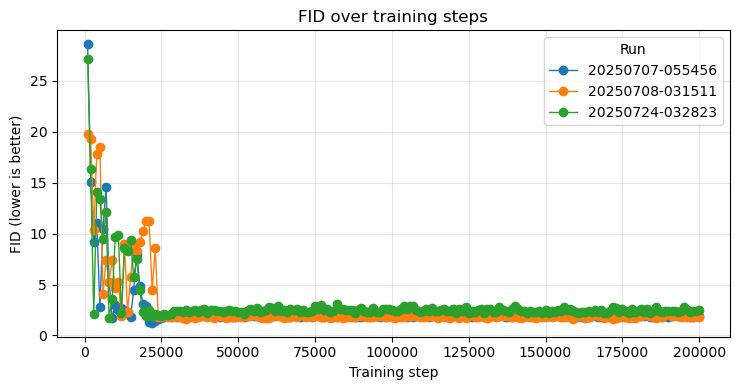

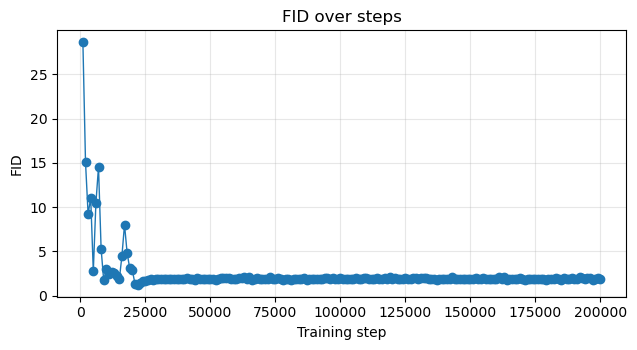

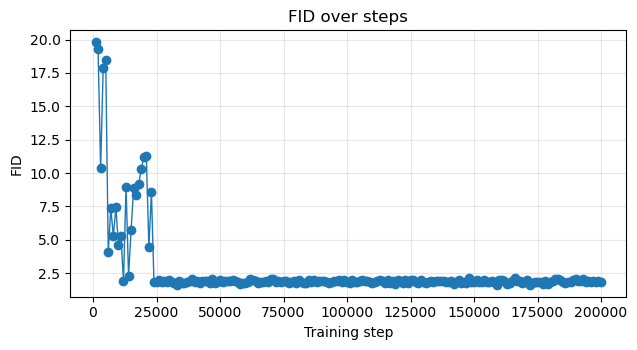

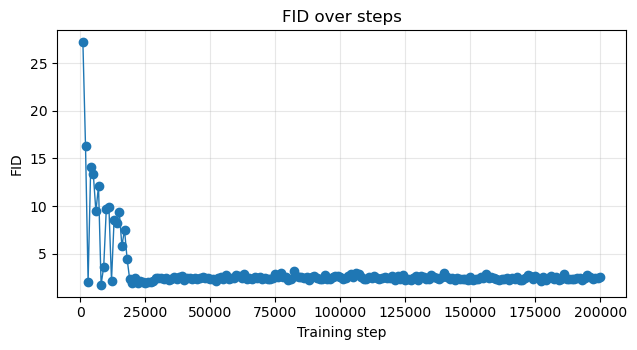

In [41]:
# --- FID only: combined across runs + per-run ---

# Require metrics table
assert 'metric_df' in globals() and not metric_df.empty, "metric_df not found or empty. Run the metrics cell first."

# Combined plot (all runs)
plt.figure(figsize=(7.5, 4.0))
for run in sorted(metric_df['run'].unique()):
    sub = metric_df[metric_df['run'] == run]
    plt.plot(sub['step'], sub['fid'], marker='o', linewidth=1, label=run)
title_suffix = "" if ('use_embeddings' in globals() and use_embeddings) else " [UMAP fallback]"
plt.title("FID over training steps" + title_suffix)
plt.xlabel("Training step"); plt.ylabel("FID (lower is better)")
plt.grid(True, alpha=0.3); plt.legend(title="Run")
plt.tight_layout()
plt.savefig(OUT_DIR / "FID_over_time__all_runs.png", dpi=200)
plt.show()

# Per-run plots
for run in sorted(metric_df['run'].unique()):
    sub = metric_df[metric_df['run'] == run]
    if sub.empty:
        continue
    plt.figure(figsize=(6.5, 3.6))
    plt.plot(sub['step'], sub['fid'], marker='o', linewidth=1)
    plt.title(f"FID over steps" + title_suffix)
    plt.xlabel("Training step"); plt.ylabel("FID")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"FID_over_time__{run}.png", dpi=200)
    plt.show()


In [22]:
# === Analysis pack config ===
from pathlib import Path

# Inputs: point to the outputs you already produced with the visualizer
OUT_DIR = Path("esm_umap_outputs")  # same as in your visualizer
EMB_REAL = OUT_DIR / "embeddings_real.npz"
EMB_GEN  = OUT_DIR / "embeddings_gen.npz"
GEN_SEL  = OUT_DIR / "gen_selected.csv"       # from Step 6 in the visualizer
FID_CSV  = OUT_DIR / "fid_esm_by_run.csv"     # from Step 13 in the visualizer

# Your training scalars (the robust parser output with correct run labels)
SCALARS_CSV = Path("/home1/zzhang201@kgi.edu/GAN/scalars_tidy_merged_fixed_runs.csv")  # <-- change me

# Real sequences (for length/AA stats). Either the REAL_FASTA you used or a CSV with 'seq'.
REAL_FASTA = Path("/home1/zzhang201@kgi.edu/GAN/zzGAN/gan/data/zz/train.fasta")  # <-- change me (FASTA)


In [23]:
# === Load data ===
import numpy as np, pandas as pd, re
from Bio import SeqIO

def load_fasta_seqs(path):
    rows = []
    for rec in SeqIO.parse(str(path), "fasta"):
        s = re.sub(r"\s+","", str(rec.seq)).upper()
        rows.append(s)
    return rows

fid_df = pd.read_csv(FID_CSV) if FID_CSV.exists() else pd.DataFrame(columns=["run","fid_esm","n_gen"])
gen_sel = pd.read_csv(GEN_SEL) if GEN_SEL.exists() else pd.DataFrame(columns=["run","id","seq","step","length"])
scalars = pd.read_csv(SCALARS_CSV) if SCALARS_CSV.exists() else pd.DataFrame(columns=["run","event_file","tag","step","wall_time_iso","value"])

E_r = np.load(EMB_REAL, allow_pickle=True)["X"] if EMB_REAL.exists() else np.empty((0,0))
E_g = np.load(EMB_GEN,  allow_pickle=True)["X"] if EMB_GEN.exists()  else np.empty((0,0))
ids_g = list(np.load(EMB_GEN, allow_pickle=True)["ids"]) if EMB_GEN.exists() else []

real_seqs = load_fasta_seqs(REAL_FASTA)
print("Loaded:", len(real_seqs), "real seqs |", len(gen_sel), "gen rows |",
      len(E_r), "real embeds |", len(E_g), "gen embeds")


Loaded: 7097 real seqs | 12000 gen rows | 3000 real embeds | 12000 gen embeds


In [24]:
# === Sequence-level stats: length, AA composition, JSDs ===
import numpy as np
from collections import Counter
from math import log2

AA = list("ACDEFGHIKLMNPQRSTVWY") + ["X","B","Z","-"]

def comp_counts(seqs):
    c = Counter()
    Ls = []
    for s in seqs:
        Ls.append(len(s))
        for ch in s:
            if ch in AA: c[ch]+=1
    return c, np.array(Ls)

def to_prob(c):
    total = sum(c.values()) or 1
    return np.array([c.get(a,0)/total for a in AA], dtype=float)

def jsd(p, q, eps=1e-12):
    p = p.clip(eps,1); q = q.clip(eps,1)
    p/=p.sum(); q/=q.sum()
    m = 0.5*(p+q)
    def H(x): return -np.sum(x*np.log2(x))
    return H(m)-0.5*H(p)-0.5*H(q)

# Real reference
rc, rL = comp_counts(real_seqs)
p_real = to_prob(rc)

rows = []
for run, g in gen_sel.groupby("run", sort=False):
    gc, gL = comp_counts(g["seq"].astype(str).tolist())
    p_gen = to_prob(gc)
    jsd_aa = jsd(p_real, p_gen)
    # Length KS statistic
    from scipy.stats import ks_2samp
    ks_stat, ks_p = ks_2samp(rL, gL) if len(gL)>0 else (np.nan, np.nan)
    rows.append((run, len(g), float(np.mean(gL)) if len(gL) else np.nan,
                 float(np.mean(rL)), float(jsd_aa), float(ks_stat), float(ks_p)))
comp_df = pd.DataFrame(rows, columns=["run","n_gen_seqs","len_mean_gen","len_mean_real","jsd_amino_acid","ks_len_stat","ks_len_p"])
comp_df


,run,n_gen_seqs,len_mean_gen,len_mean_real,jsd_amino_acid,ks_len_stat,ks_len_p
0,20250706-154628,800,160.0,122.791038,0.157493,1.0,0.0
1,20250707-055456,800,160.0,122.791038,0.151650,1.0,0.0
2,20250707-105025,800,160.0,122.791038,0.134166,1.0,0.0
3,20250708-031511,800,160.0,122.791038,0.143422,1.0,0.0
4,20250710-042044,800,160.0,122.791038,0.163185,1.0,0.0
5,20250719-054302,800,160.0,122.791038,0.149961,1.0,0.0
6,20250724-032823,800,160.0,122.791038,0.165579,1.0,0.0
7,20250726-010812,800,160.0,122.791038,0.218327,1.0,0.0
8,20250730-075807,800,160.0,122.791038,0.218191,1.0,0.0
9,20250731-023622,800,160.0,122.791038,0.378773,1.0,0.0


In [25]:
# === Coverage in ESM space: NN distance of Gen->Real (lower is better) ===
# Computes the median and 90th percentile of distances from each generated embedding to its nearest real.
import numpy as np

def nn_stats(X_ref, X_query, chunk=2000):
    if len(X_ref)==0 or len(X_query)==0: return np.nan, np.nan
    meds = []
    p90s = []
    # L2 on normalized vectors ~ cosine; you can L2-normalize to approximate cosine distance.
    Xr = X_ref / (np.linalg.norm(X_ref, axis=1, keepdims=True)+1e-9)
    for i in range(0, len(X_query), chunk):
        Q = X_query[i:i+chunk]
        Q = Q / (np.linalg.norm(Q, axis=1, keepdims=True)+1e-9)
        # dist^2 = 2 - 2*cos; but using brute-force dot to find NN
        sims = Q @ Xr.T                     # [q, r]
        idx = np.argmax(sims, axis=1)
        best = sims[np.arange(len(idx)), idx]
        # convert to cosine "distance"
        d = 1 - best                        # 0 is identical, larger is worse
        meds.append(np.median(d))
        p90s.append(np.quantile(d, 0.9))
    return float(np.median(meds)), float(np.median(p90s))

cov_rows = []
if len(E_r) and len(E_g):
    # overall coverage (all runs together)
    med, p90 = nn_stats(E_r, E_g)
    cov_rows.append(("ALL", med, p90, len(E_g)))
    # per-run (map ids_g -> run)
    run_map = gen_sel.set_index("id")["run"].to_dict()
    runs_present = sorted(set(run_map.get(i, "GEN") for i in ids_g))
    for run in runs_present:
        mask = np.array([run_map.get(i, "GEN")==run for i in ids_g], dtype=bool)
        if not mask.any(): continue
        med, p90 = nn_stats(E_r, E_g[mask])
        cov_rows.append((run, med, p90, int(mask.sum())))
cov_df = pd.DataFrame(cov_rows, columns=["run","nn_cos_med","nn_cos_p90","n_gen_emb"])
cov_df


,run,nn_cos_med,nn_cos_p90,n_gen_emb
0,ALL,0.178824,0.485588,12000
1,20250706-154628,0.033491,0.039926,800
2,20250707-055456,0.018415,0.023568,800
3,20250707-105025,0.021646,0.027206,800
4,20250708-031511,0.017767,0.026503,800
5,20250710-042044,0.071761,0.075486,800
6,20250719-054302,0.029474,0.032346,800
7,20250724-032823,0.025116,0.032462,800
8,20250726-010812,0.461117,0.541608,800
9,20250730-075807,0.630627,0.677415,800


In [26]:
# === Scalar trend summary (last-20% slope, min/max) with tag aliases ===
# Works with the robust scalars CSV (run, tag, step, value)
TAG_HINTS = {
    "G_loss": ["Generator_Loss","G_loss","gen/loss","generator/loss"],
    "D_loss": ["Discriminator_Loss","D_loss","disc/loss","critic_loss","critic/loss","w_distance"],
    "G_grad": ["Gradients/Generator","G/grad_norm","grad_norm_G"],
    "D_grad": ["Gradients/Discriminator","D/grad_norm","grad_norm_D"],
    "FR_loss": ["Anarci/FR_Loss","Quality/FR_Loss"],
    "CDR_js":  ["Anarci/CDR_JS_Loss","Quality/CDR_JS_Loss","JS_Divergence/Aggregated"],
    "Len_diff":["Length/Diff_Gen_minus_Real"],
    "Len_gen": ["Length/Generated_mean"],
    "Len_real":["Length/Real_mean"],
    "AnyHit":  ["Anarci/AnyHit"],
    "FullHit": ["Anarci/FullHit"],
    "NoHit":   ["Anarci/NoHit"],
}

def last_window_slope(df_rt, frac=0.2):
    if df_rt.empty: return np.nan
    d = df_rt.sort_values("step")
    n = len(d); w = max(3, int(n*frac))
    w = min(n, w)
    x = d["step"].iloc[-w:].to_numpy(dtype=float)
    y = d["value"].iloc[-w:].to_numpy(dtype=float)
    x = x - x.min()
    if x.ptp() == 0: return 0.0
    m = np.polyfit(x, y, 1)[0]
    return float(m)

def summarize_scalars(scalars, tag_hints):
    rows = []
    for run, g in scalars.groupby("run"):
        rec = {"run": run}
        for k, aliases in tag_hints.items():
            sub = g[g["tag"].isin(aliases)]
            if sub.empty:
                rec[f"{k}_last"] = np.nan; rec[f"{k}_slope"] = np.nan
            else:
                last = sub.sort_values(["step"]).iloc[-1]["value"]
                slope = last_window_slope(sub, frac=0.2)
                rec[f"{k}_last"] = float(last)
                rec[f"{k}_slope"] = float(slope)
        rows.append(rec)
    return pd.DataFrame(rows)

scalar_summary = summarize_scalars(scalars, TAG_HINTS)
scalar_summary


,run,G_loss_last,G_loss_slope,D_loss_last,D_loss_slope,G_grad_last,G_grad_slope,D_grad_last,D_grad_slope,FR_loss_last,...,Len_gen_last,Len_gen_slope,Len_real_last,Len_real_slope,AnyHit_last,AnyHit_slope,FullHit_last,FullHit_slope,NoHit_last,NoHit_slope
0,20250706-154628,1.355546,-2.436779e-07,-0.442076,-1.994956e-06,4.779609,5.612713e-07,4.542340,1.173421e-06,NaN,...,121.0,6.844241e-19,126.0,0.000017,NaN,NaN,NaN,NaN,NaN,NaN
1,20250707-055456,2.574754,2.080470e-07,-1.051851,-3.446419e-06,5.039855,-2.166294e-06,5.373343,-2.666432e-06,NaN,...,121.0,-9.577284e-20,125.0,-0.000004,NaN,NaN,NaN,NaN,NaN,NaN
2,20250707-105025,-0.866039,8.934339e-08,-0.765521,-2.935193e-06,4.226690,6.376234e-07,8.583044,-6.230058e-06,NaN,...,127.0,2.930145e-06,114.0,0.000021,NaN,NaN,NaN,NaN,NaN,NaN
3,20250708-031511,-2.094227,3.026790e-07,-0.354067,2.084622e-07,3.365860,5.568483e-06,4.437256,-2.914411e-07,NaN,...,121.0,-9.577284e-20,113.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
4,20250710-042044,0.569750,3.314971e-08,-1.417889,-5.410833e-07,1.866786,2.563272e-06,3.736708,3.621855e-07,NaN,...,121.0,-9.577284e-20,113.0,0.000022,NaN,NaN,NaN,NaN,NaN,NaN
5,20250719-054302,0.761561,-1.576547e-07,-1.373764,-6.837244e-07,1.872330,-2.326445e-06,3.291920,1.222238e-06,NaN,...,124.0,4.867500e-20,122.0,0.000005,NaN,NaN,NaN,NaN,NaN,NaN
6,20250724-032823,-1.119341,4.019420e-08,-1.318125,-9.906364e-07,3.066037,1.013457e-06,5.720350,1.929599e-06,0.439582,...,120.0,1.260954e-18,125.0,0.000005,NaN,NaN,NaN,NaN,NaN,NaN
7,20250726-010812,-1.301682,1.226079e-07,0.315077,-2.162337e-07,5.385637,2.539158e-06,13.249757,-1.127397e-06,1.000000,...,124.0,1.172058e-06,126.0,0.000003,NaN,NaN,NaN,NaN,NaN,NaN
8,20250730-075807,-2.447196,-9.466850e-09,-3.083601,6.281282e-07,3.933343,1.863801e-07,13.168828,-2.716545e-06,1.000000,...,133.0,4.688233e-06,124.0,0.000013,0.0,0.0,0.0,0.0,64.0,-1.075717e-19
9,20250731-023622,-3.643178,8.291910e-08,-0.561413,-5.295866e-07,3.103052,-1.327883e-07,17.790903,-3.747466e-06,1.000000,...,100.0,4.727313e-19,125.0,0.000004,0.0,0.0,0.0,0.0,64.0,-1.075717e-19


In [27]:
# === Merge all metrics into one table and save ===
summary = (fid_df
           .merge(cov_df, on="run", how="outer")
           .merge(comp_df, on="run", how="outer")
           .merge(scalar_summary, on="run", how="outer"))

summary_path = OUT_DIR / "analysis_summary.csv"
summary.to_csv(summary_path, index=False)
display(summary.sort_values("fid_esm", na_position="last"))
print("Wrote:", summary_path)


,run,fid_esm,n_gen,nn_cos_med,nn_cos_p90,n_gen_emb,n_gen_seqs,len_mean_gen,len_mean_real,jsd_amino_acid,...,Len_gen_last,Len_gen_slope,Len_real_last,Len_real_slope,AnyHit_last,AnyHit_slope,FullHit_last,FullHit_slope,NoHit_last,NoHit_slope
1,20250707-055456,1.831966,800,0.018415,0.023568,800,800.0,160.0,122.791038,0.151650,...,121.0,-9.577284e-20,125.0,-0.000004,NaN,NaN,NaN,NaN,NaN,NaN
3,20250708-031511,2.064152,800,0.017767,0.026503,800,800.0,160.0,122.791038,0.143422,...,121.0,-9.577284e-20,113.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
6,20250724-032823,2.521866,800,0.025116,0.032462,800,800.0,160.0,122.791038,0.165579,...,120.0,1.260954e-18,125.0,0.000005,NaN,NaN,NaN,NaN,NaN,NaN
0,20250706-154628,2.624580,800,0.033491,0.039926,800,800.0,160.0,122.791038,0.157493,...,121.0,6.844241e-19,126.0,0.000017,NaN,NaN,NaN,NaN,NaN,NaN
5,20250719-054302,2.692140,800,0.029474,0.032346,800,800.0,160.0,122.791038,0.149961,...,124.0,4.867500e-20,122.0,0.000005,NaN,NaN,NaN,NaN,NaN,NaN
2,20250707-105025,3.642827,800,0.021646,0.027206,800,800.0,160.0,122.791038,0.134166,...,127.0,2.930145e-06,114.0,0.000021,NaN,NaN,NaN,NaN,NaN,NaN
4,20250710-042044,9.470080,800,0.071761,0.075486,800,800.0,160.0,122.791038,0.163185,...,121.0,-9.577284e-20,113.0,0.000022,NaN,NaN,NaN,NaN,NaN,NaN
13,20250916-101929,10.176511,800,0.074637,0.129058,800,800.0,160.0,122.791038,0.151677,...,122.0,-1.661978e-05,126.0,0.000004,0.0,0.0,0.0,0.0,64.0,-1.075717e-19
15,ALL,14.002560,12000,0.178824,0.485588,12000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,20250916-171337,20.138159,800,0.356490,0.436848,800,800.0,160.0,122.791038,0.219927,...,120.0,-1.626817e-05,125.0,-0.000002,0.0,0.0,0.0,0.0,64.0,-1.075717e-19


Wrote: esm_umap_outputs/analysis_summary.csv
